In [1]:
from utils import * 

Read the data 

In [2]:
root_dir = "/neurospin/optimed/ZainebAmor/fmri_Dataset2/"
sub_d, subject_id = subject_dict(root_dir, 'sub_03')

In [3]:
clock_files_epi, anticlock_files_epi = get_Clock_AntiClock(sub_d['func'], 'func', root_dir, subject_id, method='EPI3D')
clock_files_spark, anticlock_files_spark = get_Clock_AntiClock(sub_d['func'], 'func', root_dir, subject_id)

['/neurospin/optimed/ZainebAmor/fmri_Dataset2/sub_03/func/rp_sub_03_EPI3D_ClockwiseTask.txt', '/neurospin/optimed/ZainebAmor/fmri_Dataset2/sub_03/func/ctrsub_03_EPI3D_ClockwiseTask.nii'] 
 ['/neurospin/optimed/ZainebAmor/fmri_Dataset2/sub_03/func/rp_sub_03_EPI3D_AntiClockwiseTask.txt', '/neurospin/optimed/ZainebAmor/fmri_Dataset2/sub_03/func/ctrsub_03_EPI3D_AntiClockwiseTask.nii'] 

['/neurospin/optimed/ZainebAmor/fmri_Dataset2/sub_03/func/rp_sub_03_SPARKLING3D_ClockwiseTask.txt', '/neurospin/optimed/ZainebAmor/fmri_Dataset2/sub_03/func/crsub_03_SPARKLING3D_ClockwiseTask.nii'] 
 ['/neurospin/optimed/ZainebAmor/fmri_Dataset2/sub_03/func/crsub_03_SPARKLING3D_AntiClockwiseTask.nii', '/neurospin/optimed/ZainebAmor/fmri_Dataset2/sub_03/func/rp_sub_03_SPARKLING3D_AntiClockwiseTask.txt'] 



In [4]:
retino_data_clock, retino_data_anticlock, motion_clock, motion_anticlock = load_fmri_volumes_and_confounds(clock_files_spark, 
                                                                                   anticlock_files_spark)
retino_data_clock, retino_data_anticlock, motion_clock, motion_anticlock

/volatile/Zaineb/fMRI_analysis/utils.py:36: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_clock = read_csv([f for f in clock_files if f.endswith("txt")][0], sep='  ')
/volatile/Zaineb/fMRI_analysis/utils.py:37: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_anticlock = read_csv([f for f in anticlock_files if f.endswith("txt")][0], sep='  ')


(<nibabel.nifti1.Nifti1Image at 0x7ff2874cee60>,
            tx        ty        tz        rx        ry        rz
 0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
 1    0.008175 -0.001936  0.016675  0.000068  0.000129 -0.000160
 2    0.005942 -0.000855  0.018556  0.000072  0.000145 -0.000294
 3    0.009199  0.001075  0.024648  0.000117  0.000357 -0.000346
 4    0.017168 -0.008669  0.013963  0.000305  0.000260 -0.000404
 ..        ...       ...       ...       ...       ...       ...
 115  0.031757  0.064784  0.100749  0.004404  0.004388 -0.000206
 116  0.029608  0.069884  0.099488  0.004213  0.004488 -0.000315
 117  0.024108  0.079779  0.108023  0.004212  0.004860 -0.000391
 118  0.031459  0.069902  0.092227  0.004339  0.004817 -0.000393
 119  0.051945  0.058331  0.061998  0.004304  0.004955 -0.000336
 
 [120 rows x 6 columns],
            tx        ty        tz        rx        ry        rz
 0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
 1   -0.000807

In [5]:
t1_den = load_T1(root_dir, subject_id, sub_d['anat'])

Design Matrix 

<AxesSubplot: label='conditions', ylabel='scan number'>

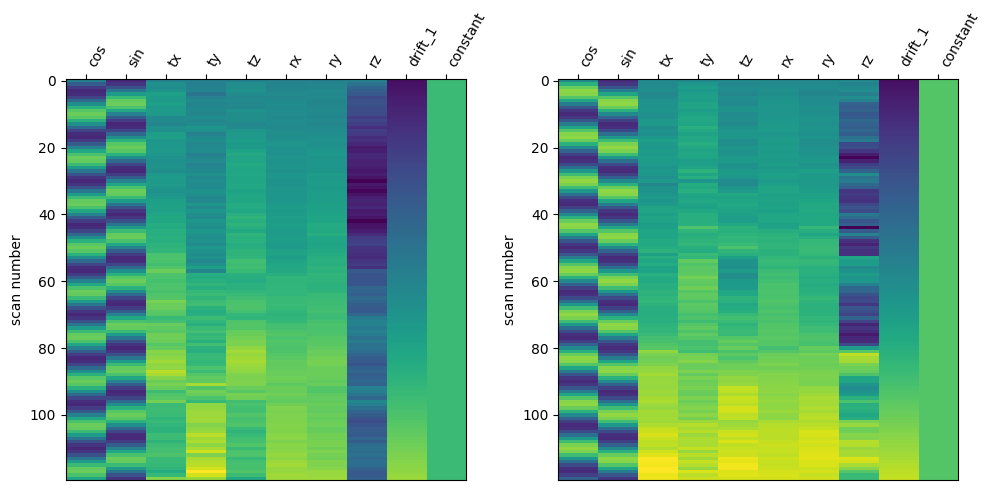

In [6]:
X_clock = make_first_level_single_sess_design_matrix(motion_clock, n_scans=120, tr=2.4,
                                                     n_cycles=9, sign=-1, hrf_model='spm')
X_anticlock = make_first_level_single_sess_design_matrix(motion_anticlock, n_scans=120, tr=2.4,
                                                         n_cycles=9, sign=1, hrf_model='spm')
design_matrices = [X_clock, X_anticlock]
design_matrices_surf = np.concatenate((X_clock.values, X_anticlock.values), axis=0)
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
plot_design_matrix(X_clock, ax=ax1)
plot_design_matrix(X_anticlock, ax=ax2)

fit GLM

In [7]:
glm_clock = make_and_fit_glm(retino_data_clock, X_clock, tr=2.4)
glm_anticlock = make_and_fit_glm(retino_data_anticlock, X_anticlock, tr=2.4)

fmri_time_series = retino_data_clock, retino_data_anticlock
glm_glob = make_and_fit_glm(fmri_time_series, design_matrices, tr=2.4)

/volatile/Zaineb/Envs/SimuEnv/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


In [8]:
rot_clock, sin_clock, cos_clock = run_glm(glm_clock, X_clock.keys() )
rot_anticlock, sin_anticlock, cos_anticlock = run_glm(glm_anticlock, X_anticlock.keys() )
rot_glob, sin_glob, cos_glob = run_glm(glm_glob, design_matrices[0].keys() )

/volatile/Zaineb/Envs/SimuEnv/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:688: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/volatile/Zaineb/Envs/SimuEnv/lib/python3.10/site-packages/nilearn/glm/contrasts.py:346: UserWarning: Running approximate fixed effects on F statistics.
  warn('Running approximate fixed effects on F statistics.')


/volatile/Zaineb/Envs/SimuEnv/lib/python3.10/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


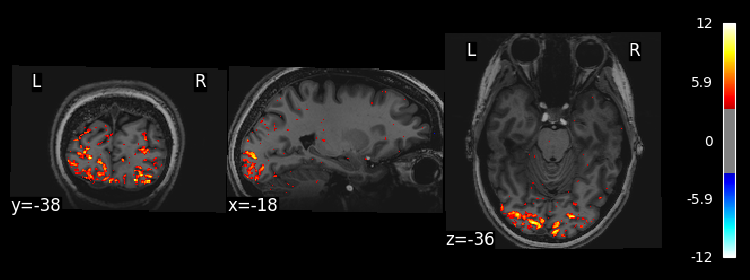

In [9]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
z_map_glob = rot_glob['z_score']
_, threshold = threshold_stats_img(z_map_glob, alpha=0.001, height_control='fpr')
plot_stat_map(z_map_glob, threshold=threshold,  bg_img=t1_den, draw_cross=False,)

save z-score maps

In [45]:
#rot_glob['z_score'].to_filename(os.path.join(os.path.join(root_dir, subject_id),'stat', 'eff_int_SPARK'))
#sin_clock['z_score'].to_filename(os.path.join(os.path.join(root_dir, subject_id),'stat', 'clock_sin_SPARK'))
#cos_clock['z_score'].to_filename(os.path.join(os.path.join(root_dir, subject_id),'stat', 'clock_cos_SPARK'))
#sin_anticlock['z_score'].to_filename(os.path.join(os.path.join(root_dir, subject_id),'stat', 'anticlock_sin_SPARK'))
#cos_anticlock['z_score'].to_filename(os.path.join(os.path.join(root_dir, subject_id),'stat', 'anticlock_cos_SPARK'))

Phase maps 

In [10]:
import nibabel as nib 
import os 
from nilearn.plotting import plot_stat_map, plot_anat, plot_img


root_folder = "/neurospin/optimed/ZainebAmor/fmri_Dataset2/"
subj = "sub_03"
tech='_SPARK'

rot_glob = nib.load(os.path.join(os.path.join(root_folder,subj,'stat'),'eff_interest'+tech+'.nii'))
sin_clock = nib.load(os.path.join(os.path.join(root_folder,subj,'stat'),'clock_sin'+tech+'.nii'))
cos_clock = nib.load(os.path.join(os.path.join(root_folder,subj,'stat'),'clock_cos'+tech+'.nii'))
sin_anticlock = nib.load(os.path.join(os.path.join(root_folder,subj,'stat'),'anticlock_sin'+tech+'.nii'))
cos_anticlock = nib.load(os.path.join(os.path.join(root_folder,subj,'stat'),'anticlock_cos'+tech+'.nii'))
t1 = nib.load("/neurospin/optimed/ZainebAmor/fmri_Dataset2/sub_03/anat/csub_03_T1.nii")

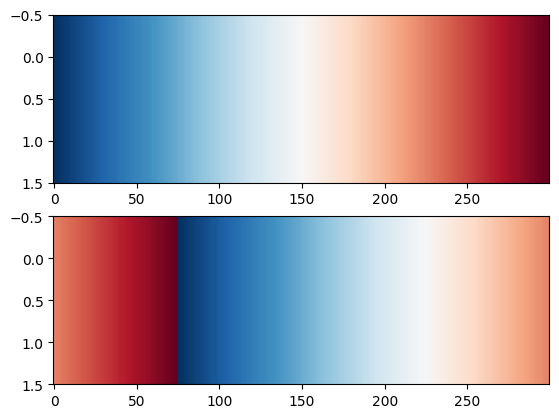

In [11]:
import matplotlib.pyplot as plt
x = np.linspace(-300,1,300)
x = np.vstack([x,x])
cmap1 = plt.get_cmap('RdBu_r')
cmap2 = shift_cmap(cmap1, 0.25)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.imshow(x, aspect='auto', cmap=cmap1)
ax2.imshow(x, aspect='auto', cmap=cmap2)

In [12]:
mask, phase_clock, phase_anticlock = get_neg_pos_phases_and_mask(rot_glob, cos_clock, sin_clock, cos_anticlock, sin_anticlock)
phase = estimate_phase(phase_clock, phase_anticlock)

In [13]:
phase = np.multiply(phase, mask)
phase[mask==False]=0
phase = nib.Nifti1Image(phase, rot_glob.affine)

/volatile/Zaineb/Envs/SimuEnv/lib/python3.10/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


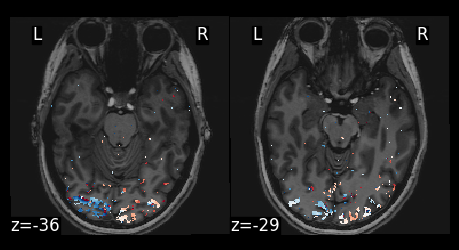

In [14]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
plot_stat_map(phase,  bg_img=t1, draw_cross=False, threshold=0.0, resampling_interpolation='nearest',
              cmap=cmap2, vmax=np.pi, colorbar=False, 
              display_mode='z', cut_coords=(-36,-29),
             )